In [1]:
import pandas as pd
import cv2

import os

import numpy as np


In [2]:
from data_augmentation.data_augmentation import DataAugmentation
dataAugm = DataAugmentation(data_dir="",
                            target_dir="/home/dmitrii/GitHub/AnomaliesRecycling/data/copy_and_paste/results",
                            zero_lid_dir='/home/dmitrii/GitHub/AnomaliesRecycling/data_augmentation/data/zero_lid.csv',
                            one_lid_dir='/home/dmitrii/GitHub/AnomaliesRecycling/data_augmentation/data/one_lid.csv')


Generating and saving masks for image 0 of 1331
Generating and saving masks for image 100 of 1331
Generating and saving masks for image 200 of 1331
Generating and saving masks for image 300 of 1331
Generating and saving masks for image 400 of 1331
Generating and saving masks for image 500 of 1331
Generating and saving masks for image 600 of 1331
Generating and saving masks for image 700 of 1331
Generating and saving masks for image 800 of 1331
Generating and saving masks for image 900 of 1331
Generating and saving masks for image 1000 of 1331
Generating and saving masks for image 1100 of 1331
Generating and saving masks for image 1200 of 1331
Generating and saving masks for image 1300 of 1331


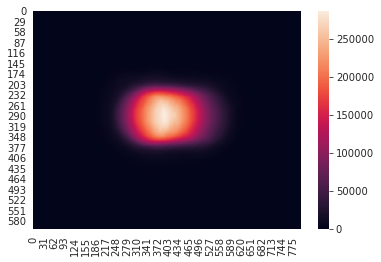

In [3]:
dataAugm.extract_masks()
summed_mask = dataAugm.get_sum_binary_mask()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

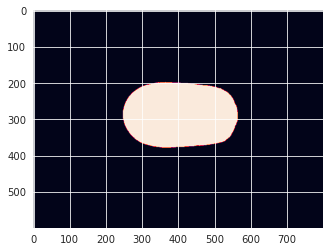

In [4]:
dataAugm.get_percentile_sum_binary_mask(summed_mask=summed_mask, percentile=90)

In [5]:
from PIL import Image
import cv2
from IPython.display import display
def show_cv(img_in):
    img = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    display(Image.fromarray(img))

248 379


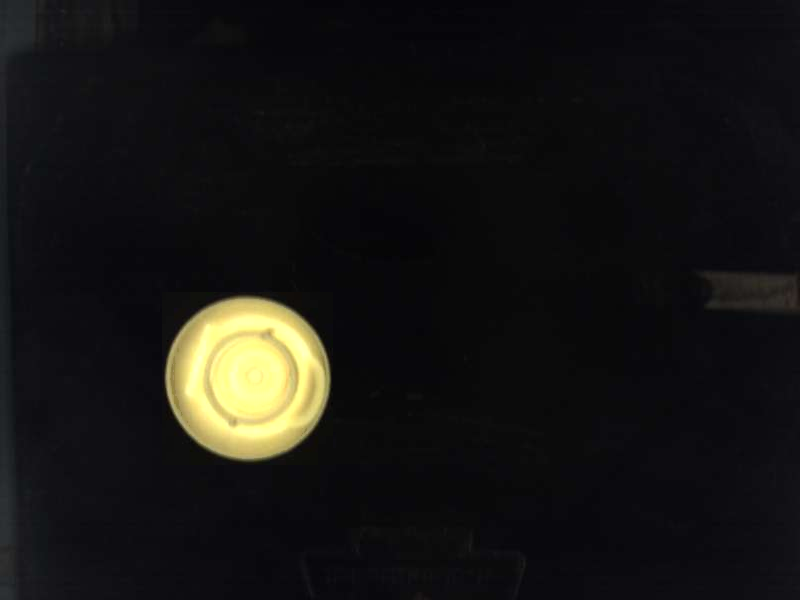

In [19]:
x, y = dataAugm.get_random_position()
show_cv(dataAugm.masks[3].copy_and_paste(dataAugm.get_random_background(), x, y))

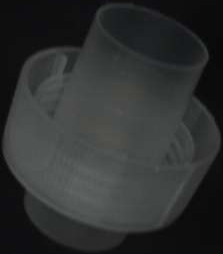

(254, 223, 3)


In [15]:
img = dataAugm.masks[0]
x,y,w,h = cv2.boundingRect(img.cnt)
image = img.image
#cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,255), 2)
image = image[y:y+h, x:x+w]
show_cv(image)
print(image.shape)

In [2]:
path_polysecure = "/home/dmitrii/GitHub/AnomaliesRecycling/POLYSECURE"

masks_path = "/home/dmitrii/GitHub/AnomaliesRecycling/data/copy_and_paste"

target_path = "/home/dmitrii/GitHub/AnomaliesRecycling/data/copy_and_paste/results"
object_csv_path = os.path.join(masks_path, 'objectmasks.csv')
object_masks = pd.read_csv(object_csv_path)

binary_csv_path = os.path.join(masks_path, 'binarymasks.csv')
binary_masks = pd.read_csv(binary_csv_path)

#if not object_masks['name'] == binary_masks['name']:
#    print('binarymasks.csv and objectmasks.csv not compatible')

empty_trays = pd.read_csv('/home/dmitrii/GitHub/AnomaliesRecycling/data_augmentation/data/zero_lid.csv')

In [3]:
#from data_augmentation.copy_and_paste import get_empty_tray, get_object_and_binary_masks
binary_masks

,Unnamed: 0,name,binary_mask_names
0,0,/cluttered/Anlerndaten (1032).jpg,binary_mask_0.jpg
1,1,/presorted/trial (313).jpg,binary_mask_1.jpg
2,2,/cluttered/Anlerndaten (477).jpg,binary_mask_2.jpg
3,3,/presorted/trial (1694).jpg,binary_mask_3.jpg
4,4,/presorted/trial (433).jpg,binary_mask_4.jpg
...,...,...,...
1326,1326,/presorted/trial (36).jpg,binary_mask_1326.jpg
1327,1327,/presorted/trial (437).jpg,binary_mask_1327.jpg
1328,1328,/presorted/trial (442).jpg,binary_mask_1328.jpg
1329,1329,/presorted/trial (422).jpg,binary_mask_1329.jpg


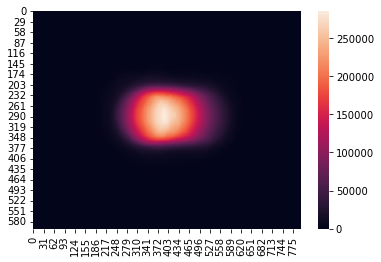

In [22]:
def get_object_and_binary_masks(index):
    object_name = object_masks.iloc[index]['object_names']
    object_path = os.path.join(masks_path, 'objects', object_name)
    object_mask = cv2.imread(object_path)

    binary_name = binary_masks.iloc[index]['binary_mask_names']
    binary_path = os.path.join(masks_path, 'binary_masks', binary_name)
    binary_mask_rbg = cv2.imread(binary_path)
    binary_mask = cv2.cvtColor(binary_mask_rbg, cv2.COLOR_RGB2GRAY)
    return object_mask, binary_mask

summed_mask = np.zeros((600,800))
for i in range(len(binary_masks)):
    object_mask, binary_mask = get_object_and_binary_masks(i)
    binary_mask = cv2.bitwise_not(binary_mask)
    summed_mask += binary_mask

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(summed_mask)#, linewidth=0.5)
plt.show()

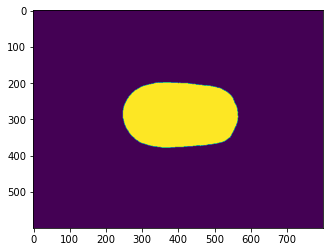

In [92]:
percentile_mask = np.where(summed_mask > np.percentile(summed_mask, 90), 1, 0)
plt.imshow(percentile_mask)

In [89]:
np.shape(percentile_mask[percentile_mask==0])

(456000,)

In [126]:
#np.where(percentile_mask==1)[0]
from random import seed
from random import randint

print(np.shape(percentile_mask.flatten()))

indexes = percentile_mask.nonzero()
print(np.shape(indexes))
i = randint(0, np.shape(indexes)[1])
x, y = indexes[0][i], indexes[1][i]
print(x,y)

(480000,)
(2, 48000)
268 335


In [122]:
contours,_ = cv2.findContours(object_mask.copy(), 1, 1)
rect = cv2.minAreaRect(contours) # basically you can feed this rect into your classifier
(x,y),(w,h), a = rect # a - angle

box = cv2.boxPoints(rect)
box = np.int0(box) #turn into ints
rect2 = cv2.drawContours(object_mask.copy(),[box],0,(0,0,255),10)

plt.imshow(rect2)
plt.show()


error: OpenCV(4.5.4) /tmp/pip-req-build-24v3eisa/opencv/modules/imgproc/src/contours.cpp:195: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


342 334


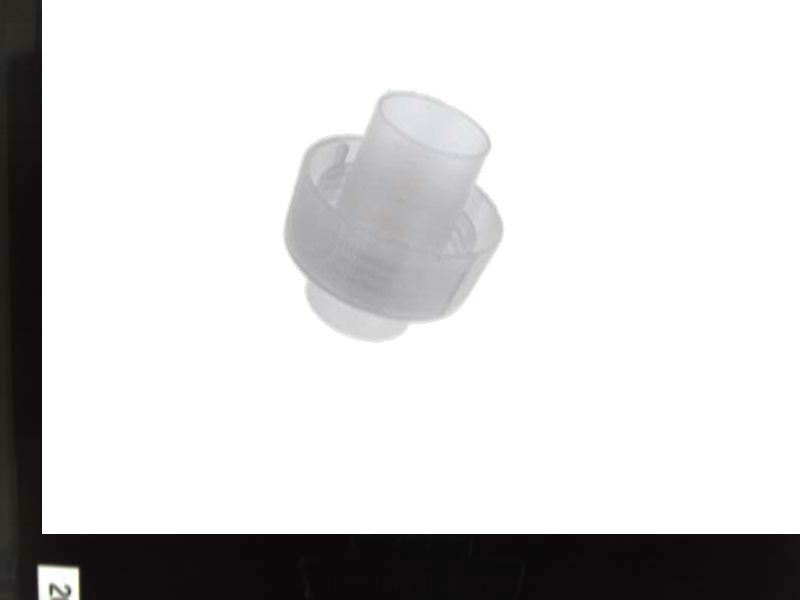

In [193]:
from IPython.core.display_functions import display
from random import randint

indexes = percentile_mask.nonzero()
i = randint(0, np.shape(indexes)[1])
x, y = indexes[0][i], indexes[1][i]
print(x,y)

inverted_bin_mask = (255-binary_mask)
indexes = inverted_bin_mask.nonzero()
x_min, x_max = np.min(indexes[0]), np.max(indexes[0])
y_min, y_max = np.min(indexes[1]), np.max(indexes[1])
x_middle = int((x_min + x_max)/2)
y_middle = int((y_min + y_max)/2)


def get_empty_tray(index):
    empty_tray_name = empty_trays.iloc[index]['name'][1:]
    empty_tray_path = os.path.join(path_polysecure, empty_tray_name)
    empty_tray = cv2.imread(empty_tray_path)
    return empty_tray
empty_tray = get_empty_tray(0)
object_mask, binary_mask = get_object_and_binary_masks(0)
from PIL import Image, ImageDraw, ImageFilter
im_empty = Image.fromarray(empty_tray)
im_obj = Image.fromarray(cv2.bitwise_not(object_mask))
#im_empty.paste(im_obj, (x-x_middle,y-y_middle))
im_empty.paste(im_obj, (x-300,y-400))

#plt.imshow(im_empty)
display(im_empty)
#display(im_obj)

In [151]:
inverted_bin_mask = (255-binary_mask)
indexes = inverted_bin_mask.nonzero()
x_min, x_max = np.min(indexes[0]), np.max(indexes[1])
print(x_min, x_max)
print(int((x_max+x_min)/2))

152 463
307
